# Import Libraries

In [1]:
# Retrieve files from Google Drive
from google.colab import drive

# Import data structures
import pandas as pd
import numpy as np

# Import visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Import preprocessing libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize

# Import model
from xgboost import XGBClassifier, XGBRegressor

# Import model metrics
from sklearn.metrics import accuracy_score, auc, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, log_loss, roc_curve
from sklearn.metrics import precision_recall_curve, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prepare Dataset

## Retrieve Dataset from Google

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Convert csv file to pandas DataFrame
all_flights = pd.read_csv("/content/drive/MyDrive/CSCI334/Project/clean_flight_status.csv")

In [5]:
# Look at the first five rows
all_flights.head()

,FlightDate,Airline,Origin,Dest,CRSDepTime,DepDelay,ArrTime,CRSElapsedTime,Distance,Quarter,...,ArrTimeBlk,Operating_Airline,flight_status,Prev_Arrtime,Prev_Dest,Layover_Time,ShortLayover,Prev_ArrDelay,PrevFlightDelayed,Layover_Risk
0,2018-01-01,Allegiant Air,FLL,MEM,600,7.0,748.0,153.0,851.0,1,...,0700-0759,G4,On Time,0.0,NaN,0.0,False,0.0,False,False
1,2018-01-01,Allegiant Air,MEM,FLL,823,3.0,1144.0,136.0,851.0,1,...,1100-1159,G4,On Time,748.0,MEM,78.0,False,15.0,False,False
2,2018-01-01,Allegiant Air,FLL,GSP,1229,17.0,1451.0,112.0,620.0,1,...,1400-1459,G4,Delayed,1144.0,FLL,102.0,False,5.0,False,False
3,2018-01-01,Allegiant Air,GSP,FLL,1506,25.0,1732.0,109.0,620.0,1,...,1600-1659,G4,Delayed,1451.0,GSP,80.0,False,30.0,True,False
4,2018-01-01,Allegiant Air,FLL,ORF,1745,68.0,2058.0,125.0,781.0,1,...,1900-1959,G4,Delayed,1732.0,FLL,121.0,False,37.0,True,False


## Clean Dataset

In [6]:
all_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29193782 entries, 0 to 29193781
Data columns (total 34 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   FlightDate                       object 
 1   Airline                          object 
 2   Origin                           object 
 3   Dest                             object 
 4   CRSDepTime                       int64  
 5   DepDelay                         float64
 6   ArrTime                          float64
 7   CRSElapsedTime                   float64
 8   Distance                         float64
 9   Quarter                          int64  
 10  Marketing_Airline_Network        object 
 11  Year                             int64  
 12  Month                            int64  
 13  DayOfWeek                        int64  
 14  DOT_ID_Operating_Airline         int64  
 15  Tail_Number                      object 
 16  Flight_Number_Operating_Airline  int64  
 17  Flight

In [7]:
# Convert FlightDate to dateTime format
all_flights["FlightDate"] = pd.to_datetime(all_flights["FlightDate"])

In [8]:
# Convert all columns to string
object_columns = all_flights.select_dtypes(include=['object']).columns  # Get list of applicable columns
all_flights[object_columns] = all_flights[object_columns].astype("string")  # and convert stored values to String

In [9]:
all_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29193782 entries, 0 to 29193781
Data columns (total 34 columns):
 #   Column                           Dtype         
---  ------                           -----         
 0   FlightDate                       datetime64[ns]
 1   Airline                          string        
 2   Origin                           string        
 3   Dest                             string        
 4   CRSDepTime                       int64         
 5   DepDelay                         float64       
 6   ArrTime                          float64       
 7   CRSElapsedTime                   float64       
 8   Distance                         float64       
 9   Quarter                          int64         
 10  Marketing_Airline_Network        string        
 11  Year                             int64         
 12  Month                            int64         
 13  DayOfWeek                        int64         
 14  DOT_ID_Operating_Airline        

In [10]:
all_flights.isna().sum()

,0
FlightDate,0
Airline,0
Origin,0
Dest,0
CRSDepTime,0
DepDelay,0
ArrTime,0
CRSElapsedTime,0
Distance,0
Quarter,0


In [11]:
# Replace missing values in Prev_Dest to Not Applicable
all_flights["Prev_Dest"].fillna("Not Applicable", inplace=True)

<ipython-input-11-0fcd614137ac>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_flights["Prev_Dest"].fillna("Not Applicable", inplace=True)


In [12]:
all_flights.isna().sum()

,0
FlightDate,0
Airline,0
Origin,0
Dest,0
CRSDepTime,0
DepDelay,0
ArrTime,0
CRSElapsedTime,0
Distance,0
Quarter,0


# XGBoost Classification Model


## Preprocess the Dataset

Turn Objects into String:

### Define X and y


In [13]:
y_classifier = all_flights["flight_status"]
y_regressor = all_flights["DepDelay"]
X = all_flights.drop(columns=["flight_status", "FlightDate", "DepDelay"])

### Encode the target & Attributes

Encode the target class:

In [14]:
# Initialize the label encoder
le = LabelEncoder()

# Fit and transform the target variable
y_encoded = le.fit_transform(y_classifier)

# Check class mapping
dict(zip(le.classes_, le.transform(le.classes_)))

{'Canceled': np.int64(0), 'Delayed': np.int64(1), 'On Time': np.int64(2)}

### Encode the String and Category Attributes used for Predictions

In [15]:
cat_cols = X.select_dtypes(include=['string']).columns
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

### Train, Test, Split

Split dataset into train and test:

In [16]:
# Sample a subset
X_sample = X.sample(n=2_000_000, random_state=42)
y_class_sample = y_encoded[X_sample.index]
y_reg_sample = y_regressor[X_sample.index]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_sample,
                                                    y_class_sample,
                                                    test_size=0.2,
                                                    stratify=y_class_sample,
                                                    random_state=42,
                                                    shuffle=True
                                                    )

In [18]:
all_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29193782 entries, 0 to 29193781
Data columns (total 34 columns):
 #   Column                           Dtype         
---  ------                           -----         
 0   FlightDate                       datetime64[ns]
 1   Airline                          string        
 2   Origin                           string        
 3   Dest                             string        
 4   CRSDepTime                       int64         
 5   DepDelay                         float64       
 6   ArrTime                          float64       
 7   CRSElapsedTime                   float64       
 8   Distance                         float64       
 9   Quarter                          int64         
 10  Marketing_Airline_Network        string        
 11  Year                             int64         
 12  Month                            int64         
 13  DayOfWeek                        int64         
 14  DOT_ID_Operating_Airline        

## Train the model

### Initialize the model

In [19]:
# Calculate weights for class imbalances
# Calculate weights manually
cancelled_count = (y_train == 0).sum()
delayed_count = (y_train == 1).sum()
on_time_count = (y_train == 2).sum()

# Example: weight Delayed class up
weight_for_delayed = on_time_count / delayed_count

In [20]:
param_grid = {
'max_depth': [4, 6, 8],
    'n_estimators': [50, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2]  # 0.2 is best value so far
}

In [21]:
xgb_model = XGBClassifier(
    objective='multi:softprob',   # Multiclass probability output
    num_class=3,
    eval_metric='mlogloss',
    scale_pos_weight=weight_for_delayed,
    use_label_encoder=False,
    random_state=42,
)

In [22]:
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,                    # 3-fold cross-validation
    verbose=2,
    n_jobs=-1                # Use all processors
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:41:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=3,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [4, 6, 8], 'n_estimators': [50, 100],
                         'subsample': [0.8, 1.0]},
             scoring='f1_macro', verbose=2)

In [23]:
print("Best Parameters:", grid_search.best_params_)
print("Best Macro F1 Score:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
Best Macro F1 Score: 0.9503132246063638


In [24]:
# Binarize the labels
# Assuming classes are [0=canceled, 1=delayed, 2=on_time]
n_classes = 3
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

## Model Performance

### Generalize the Test Set

## Grid Search Model Performance

Check accuracy:

In [25]:
y_proba = grid_search.predict_proba(X_test)
y_pred = grid_search.predict(X_test)

In [26]:
grid_search.score(X_test, y_test)

0.951048279734005

In [27]:
accuracy_score(y_test, y_pred)

0.9616325

Check loss:

In [28]:
log_loss(y_test, y_proba)

0.1021188682276414

Check performance report:

In [29]:
# create dictionary of classification report
class_report = classification_report(y_test, y_pred, output_dict=True)

# create dataframe of classification report
report_df = pd.DataFrame(class_report).transpose()

# Display classification report
report_df

,precision,recall,f1-score,support
0,0.995034,0.999623,0.997323,10623.000000
1,0.932900,0.831561,0.879320,67128.000000
2,0.965769,0.987476,0.976501,322249.000000
accuracy,0.961633,0.961633,0.961633,0.961633
macro avg,0.964567,0.939553,0.951048,400000.000000
weighted avg,0.961030,0.961633,0.960745,400000.000000


Generate confusion matrix:

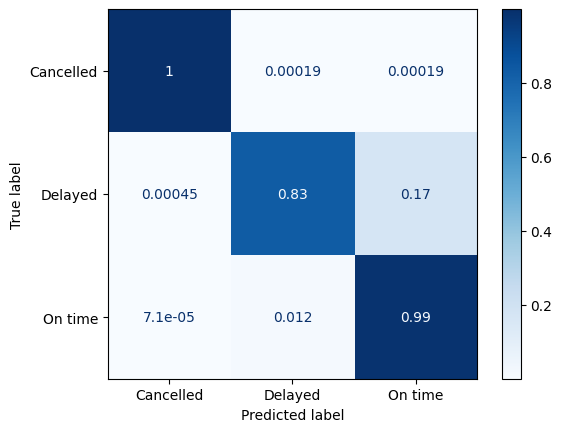

In [30]:
# Plot the confusion matrix
unique_labels = ["Cancelled", "Delayed", "On time"]

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=unique_labels,
    cmap='Blues',
    normalize='true'
)

Generate PR Curve:

In [31]:
# Binarize the labels
# Assuming classes are [0=canceled, 1=delayed, 2=on_time]
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

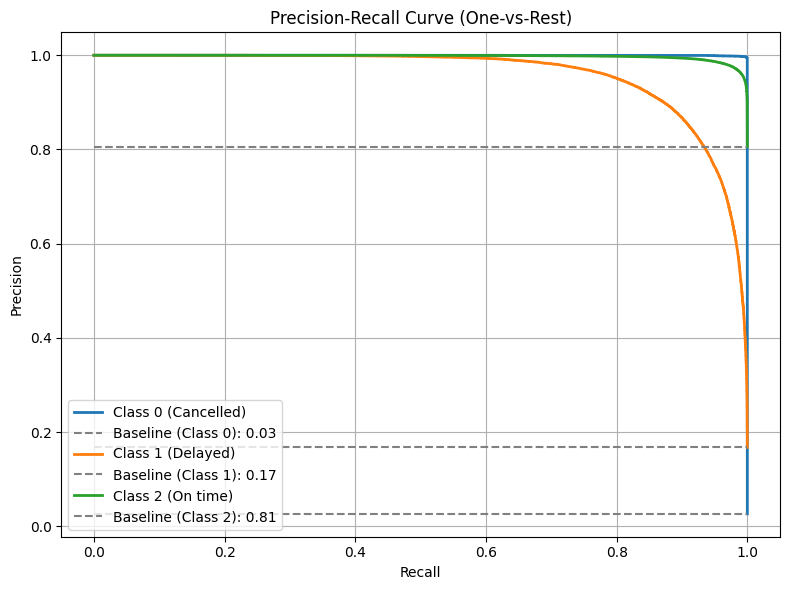

In [32]:
# Plot PR Curves for Each Class
plt.figure(figsize=(8, 6))

# For each class,
for i in range(n_classes):    # Plot the precision recall curbe
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i],
                                                  y_proba[:, i])
    plt.plot(recall, precision, lw=2, label=f"Class {i} ({unique_labels[i]})")

     # Add baseline precision line
    baseline = y_test_bin[:, i].sum() / y_test_bin[:, i].shape[0]
    plt.hlines(y=baseline, xmin=0, xmax=1, linestyles='dashed', colors='gray',
               label=f"Baseline (Class {i}): {baseline:.2f}")

# Plot labels
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (One-vs-Rest)")

# Plot format
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Generate ROC Curve:

In [33]:
auc_score = roc_auc_score(y_test_bin, y_proba, multi_class='ovr', average=None)
for i, score in enumerate(auc_score):
    print(f"ROC AUC for {unique_labels[i]}: {score:.4f}")

ROC AUC for Cancelled: 1.0000
ROC AUC for Delayed: 0.9888
ROC AUC for On time: 0.9901


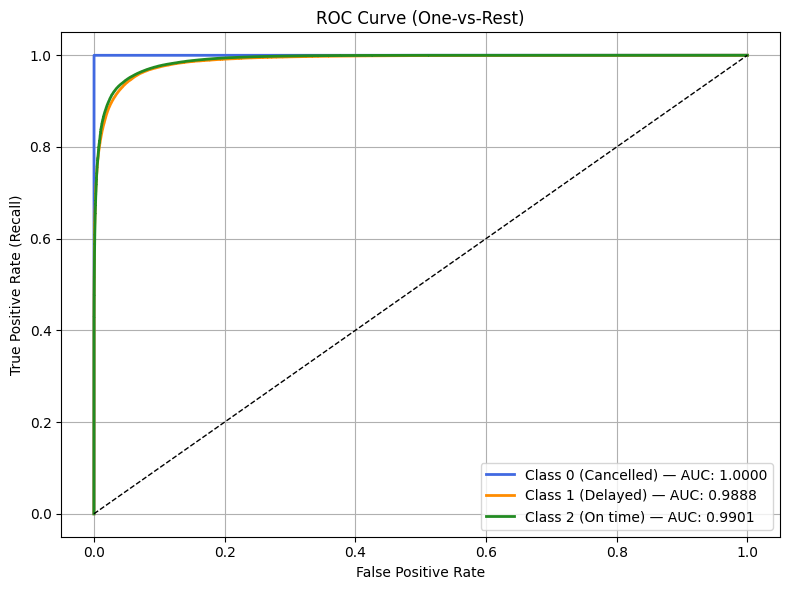

In [34]:
# Plot the ROC Curve
plt.figure(figsize=(8, 6))

# Determine the colors for each class
colors = ['royalblue', 'darkorange', 'forestgreen']

# For each class,
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,   # Plot the ROC curve
             label=f"Class {i} ({unique_labels[i]}) — AUC: {roc_auc:.4f}")

# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# Plot labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve (One-vs-Rest)')

# Plot format
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

plt.show()

# XGBoost Regression Model

## Transfer Delayed Flights to Classification Model

### Preprocess the Features

In [35]:
# Get only the delayed flights
delayed_flights = all_flights[all_flights["flight_status"] == "Delayed"]

In [36]:
# Remove any outliers
delayed_flights = delayed_flights[delayed_flights["DepDelay"] < 1440]

In [37]:
# Get X and y
X_reg = delayed_flights.drop(columns=["flight_status", "FlightDate", "DepDelay"])
y_reg = delayed_flights["DepDelay"]

In [38]:
# Transform String datatype attributes for model compatibility
cat_cols = X_reg.select_dtypes(include=['string']).columns
for col in cat_cols:
    le = LabelEncoder()
    X_reg[col] = le.fit_transform(X_reg[col])

In [39]:
# Split train test sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg,
                                                                    y_reg,
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                    shuffle=True
                                                                    )

# Create the model

In [40]:
# Initialize the regressor
xgb_regressor = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42
)

In [41]:
# Implement Grid search
grid_search_reg = GridSearchCV(
    estimator=xgb_regressor,
    param_grid=param_grid,
    cv=3,
    verbose=2,
    n_jobs=-1
)

In [42]:
grid_search_reg.fit(X_train_reg, y_train_reg)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [4, 6, 8], 'n_estimators': [50, 100],
                         'subsample': [0.8, 1.0]},
             verbose=2)

### Determine the Best Learner & Parameters

In [43]:
print("Best Parameters:", grid_search_reg.best_params_)
print("Best Score:", grid_search_reg.best_score_)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 100, 'subsample': 1.0}
Best Score: 0.9470605796128636


## Regression Model Performance

### Make Predictions on test set

In [44]:
y_pred_reg = grid_search_reg.predict(X_test_reg)

### Check metrics

In [45]:
# Find the mean absolute error
mae = mean_absolute_error(y_test_reg, y_pred_reg)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 9.015014735867705


In [46]:
# Find the Root Mean Squared Error
rmse = mean_squared_error(y_test_reg, y_pred_reg)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 440.5173330902582


In [47]:
# Find the R^2 score
r2 = r2_score(y_test_reg, y_pred_reg)
print("R^2 Score:", r2)

R^2 Score: 0.945004688900129


In [48]:
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

MAE: 9.02
RMSE: 440.52
R²: 0.945


### Visualizations of Performance

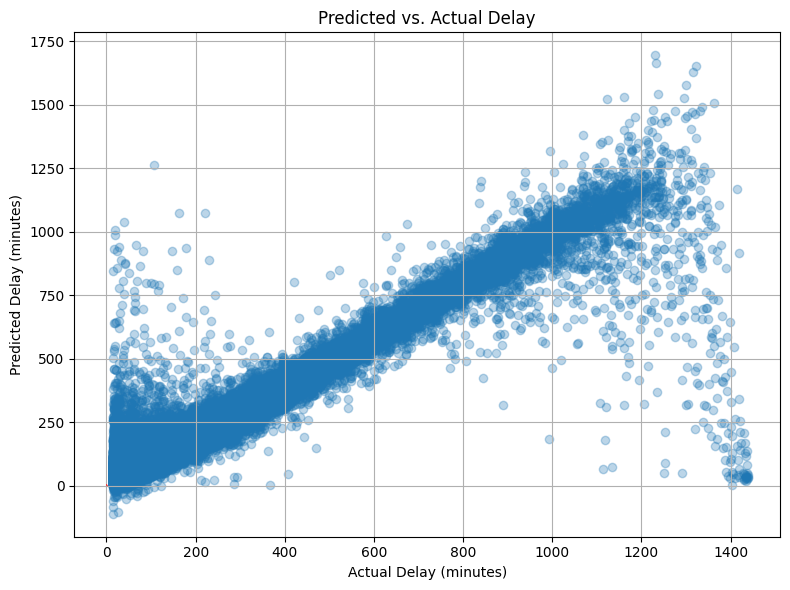

In [49]:
# Predicted versus Actual Plot
  # Shows how close predicttions are to labels
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.3)

# Plot the data
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')

# Figure labels
plt.xlabel("Actual Delay (minutes)")
plt.ylabel("Predicted Delay (minutes)")
plt.title("Predicted vs. Actual Delay")

# Figure Customizations
plt.grid(True)
plt.tight_layout()

plt.show()

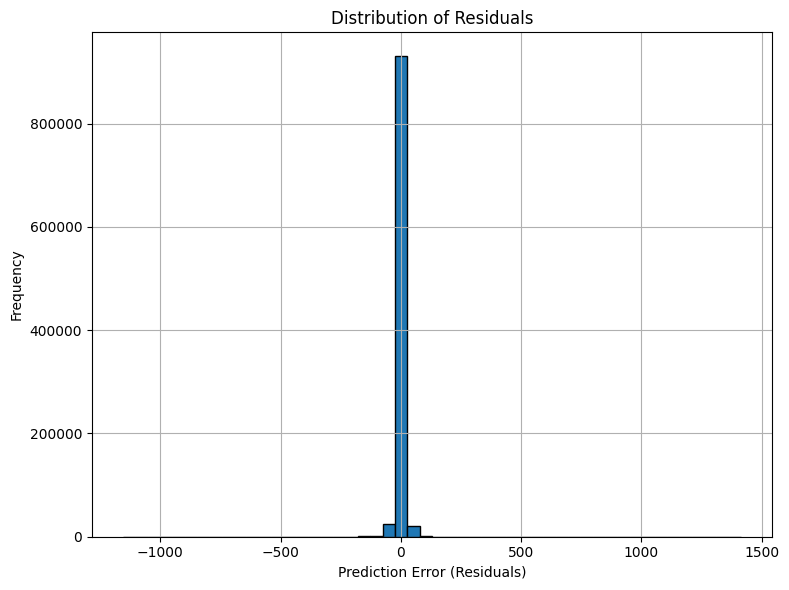

In [50]:
# Residual Plot
  # Shows how far predictions are off

residuals = y_test_reg - y_pred_reg
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, edgecolor='black')

# Figure labels
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")

# Figure Customizations
plt.grid(True)
plt.tight_layout()

plt.show()

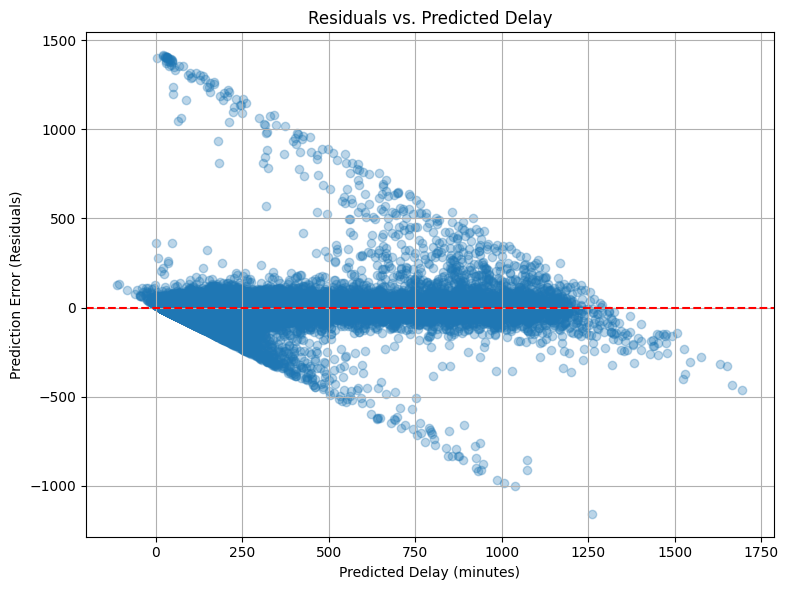

In [51]:
# Residuals vs. Predicted
  # Checks if model has bias

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_reg, residuals, alpha=0.3)

plt.axhline(y=0, color='r', linestyle='--')

# Figure labels
plt.xlabel("Predicted Delay (minutes)")
plt.ylabel("Prediction Error (Residuals)")
plt.title("Residuals vs. Predicted Delay")

# Customize plot
plt.grid(True)
plt.tight_layout()

plt.show()

# Hybrid Model on Unseen Data

## Get Unseen Data

In [103]:
# Get data that is not sampled - not used for model training
X_unsampled = X.drop(X_sample.index)
y_class_unsampled = y_classifier.drop(X_sample.index)
y_reg_unsampled = y_regressor.drop(X_sample.index)

## Preprocess Data

In [104]:
# Sample a subset to simulate real world data
X_sample = X_unsampled.sample(n=500_000)
y_class_sample = y_class_unsampled.loc[X_sample.index]
y_reg_sample = y_reg_unsampled.loc[X_sample.index]

In [105]:
y_class_sample

,flight_status
22853109,On Time
25124005,Delayed
6244933,Delayed
25280351,Delayed
2801387,On Time
...,...
3276980,On Time
13787858,On Time
27253801,On Time
14653276,On Time


In [106]:
y_class_sample.value_counts()

,count
flight_status,
On Time,402725
Delayed,84071
Canceled,13204


## Feed "real" Data into trained models

In [107]:
# Feed the trained classifier the data
y_pred_class = grid_search.predict(X_sample)

In [108]:
# Predict class
y_pred_class = grid_search.predict(X_sample)

# Mask for predicted delayed flights
delayed_mask = (y_pred_class == 1)

# Filter inputs and targets
delayed_flights = X_sample[delayed_mask]
y_delayed = y_reg_sample[delayed_mask]

In [109]:
# Filter corresponding delay durations using the same mask
y_delayed = y_reg_sample[delayed_mask]

In [110]:
# Generalize delay durations of predicted flights
y_pred_reg = grid_search_reg.predict(delayed_flights)

## Check performance metrics

In [111]:
# Check regressor metrics
mae = mean_absolute_error(y_delayed, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_delayed, y_pred_reg))
r2 = r2_score(y_delayed, y_pred_reg)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

MAE: 10.91
RMSE: 30.38
R²: 0.895


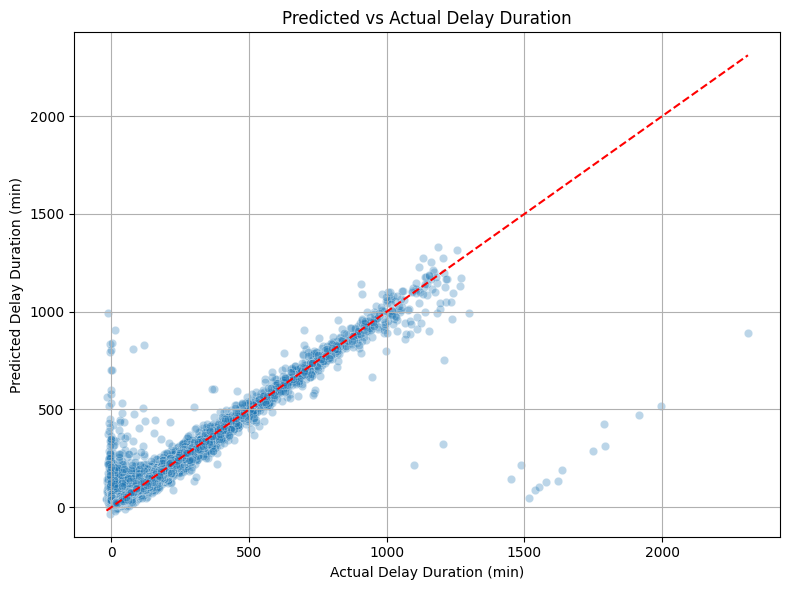

In [113]:
# Predicted vs actual delay predictions
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_delayed, y=y_pred_reg, alpha=0.3)
plt.xlabel("Actual Delay Duration (min)")
plt.ylabel("Predicted Delay Duration (min)")
plt.title("Predicted vs Actual Delay Duration")
plt.plot([y_delayed.min(), y_delayed.max()], [y_delayed.min(), y_delayed.max()], 'r--')  # reference line
plt.grid(True)
plt.tight_layout()
plt.show()

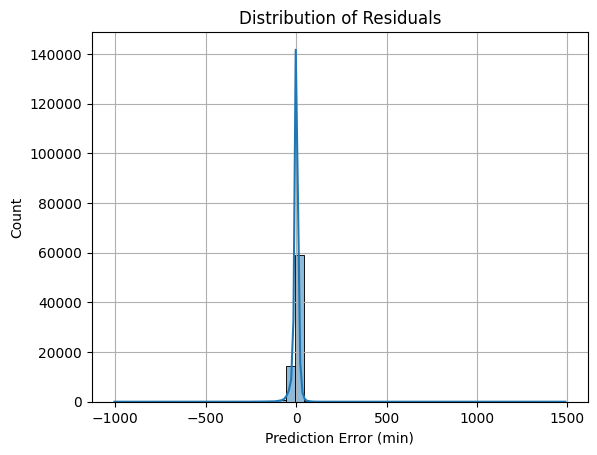

In [114]:
# Residual Prediction Plot
residuals = y_delayed - y_pred_reg
sns.histplot(residuals, kde=True, bins=50)
plt.title("Distribution of Residuals")
plt.xlabel("Prediction Error (min)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Save Notebook

In [ ]:
!pip install nbconvert
# You also need to install latex-related package in order to convert a notebook to pdf file.
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc

In [ ]:
!apt-get update
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc -y


In [ ]:
!cp /content/drive/MyDrive/CSCI334/Project/FlightStatus_XGBoostClassification.ipynb ./
!jupyter nbconvert --to pdf FlightStatus_XGBoostClassification.pdf